<a href="https://colab.research.google.com/github/CristinaMarsh/Learning_/blob/main/TStool/GluontsDay2_2_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gluonts
!pip install mxnet-cu101

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 7.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 360.0 MB 19 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


# Case1 

thanks https://github.com/URJ5329/Climate_TS_GluonTS/blob/main/Climate_GluonTS.ipynb

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import plotly.express as px

from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.model import deepar
from gluonts.dataset import common
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator, make_evaluation_predictions

In [3]:
! git clone https://github.com/URJ5329/Climate_TS_GluonTS.git

Cloning into 'Climate_TS_GluonTS'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [5]:
%cd Climate_TS_GluonTS/

/content/Climate_TS_GluonTS


In [6]:
df=pd.read_csv('DailyDelhiClimateTrain.csv')
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [7]:
df.set_index('date',inplace=True)
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [53]:
df=pd.read_csv('DailyDelhiClimateTrain.csv')
df=df.iloc[:-1,:2]
df.set_index('date',inplace=True)

In [55]:
test_df = pd.read_csv('DailyDelhiClimateTest.csv')
test_df = test_df.iloc[:,:2]
test_df.set_index('date',inplace=True)

In [57]:
from pandas._libs import index
from typing import List
data = common.ListDataset([{
    "start": df.index[0],
    "target": df.meantemp
}],freq="1D")

test_data = common.ListDataset(
    [{"start": test_df.index[0], "target": test_df.meantemp}],
    freq = "1D"
)

concat_df = pd.concat([df,test_df])
concat_data = common.ListDataset(
    [{"start": concat_df.index[0], "target": concat_df.meantemp}],
    freq = "1D"
)

In [59]:
trainer = Trainer(epochs=10)
estimator = deepar.DeepAREstimator(freq="1D", prediction_length=len(test_df), trainer=trainer)
predictor = estimator.train(training_data=data)

100%|██████████| 50/50 [00:08<00:00,  6.12it/s, epoch=10/10, avg_epoch_loss=1.85]


In [62]:
prediction = next(predictor.predict(data))

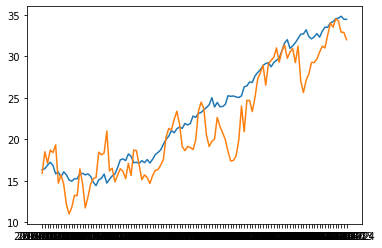

In [64]:
plt.plot(prediction.quantile(0.5))
plt.plot(test_df['meantemp'])

In [65]:
fig = px.line(x=concat_df.index,y=concat_df['meantemp'])
fig.add_scatter(y=prediction.mean,x=test_df.index)
fig.add_vrect(x0=test_df.index[0], x1=test_df.index[-1])
fig.show()

In [66]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=concat_data, 
    predictor=predictor,
    num_samples=len(test_df),  
)

In [67]:
forecasts = list(forecast_it)
tss = list(ts_it)

ts_entry = tss[0]
forecast_entry = forecasts[0]

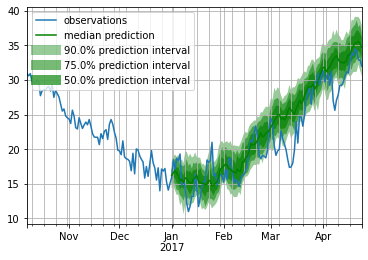

In [69]:

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 200
    prediction_intervals = (50.0, 75.0,90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    ts_entry[-plot_length:].plot()
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

plot_prob_forecasts(ts_entry, forecast_entry)

In [70]:
#Evaluation
evaluator = Evaluator([0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


In [71]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 9.04186155084978,
    "abs_error": 265.66265869140625,
    "abs_target_sum": 2475.291015625,
    "abs_target_mean": 21.713079084429825,
    "seasonal_error": 1.2366545376712328,
    "MASE": 1.884418103891645,
    "MAPE": 0.11799010059289765,
    "sMAPE": 0.10998863086365816,
    "MSIS": 15.958190788429889,
    "QuantileLoss[0.5]": 265.6626615524292,
    "Coverage[0.5]": 0.7368421052631579,
    "QuantileLoss[0.9]": 111.27852268218992,
    "Coverage[0.9]": 0.9473684210526315,
    "RMSE": 3.006968831040618,
    "NRMSE": 0.1384865232309165,
    "ND": 0.10732582836298446,
    "wQuantileLoss[0.5]": 0.10732582951881743,
    "wQuantileLoss[0.9]": 0.04495573327732238,
    "mean_absolute_QuantileLoss": 188.47059211730956,
    "mean_wQuantileLoss": 0.0761407813980699,
    "MAE_Coverage": 0.14210526315789468,
    "OWA": NaN
}


In [72]:

item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,9.041862,265.662659,2475.291016,21.713079,1.236655,1.884418,0.11799,0.109989,0.107326,15.958191,265.662662,0.736842,111.278523,0.947368


## Case2

thanks
https://github.com/fissehab/deepAR_gluonts/blob/main/DeepAR%20From%20GluonTS.py

In [73]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
!unzip LD2011_2014.txt.zip

--2022-07-05 18:31:53--  https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261335609 (249M) [application/x-httpd-php]
Saving to: ‘LD2011_2014.txt.zip’

LD2011_2014.txt.zip 100%[===================>] 249.23M  79.3MB/s    in 3.4s    

2022-07-05 18:31:57 (74.3 MB/s) - ‘LD2011_2014.txt.zip’ saved [261335609/261335609]

Archive:  LD2011_2014.txt.zip
  inflating: LD2011_2014.txt         
   creating: __MACOSX/
  inflating: __MACOSX/._LD2011_2014.txt  


In [74]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
import numpy as np

In [75]:
df = pd.read_csv('LD2011_2014.txt', sep = ';', index_col = 0, parse_dates = True, decimal = ',')

In [76]:
df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


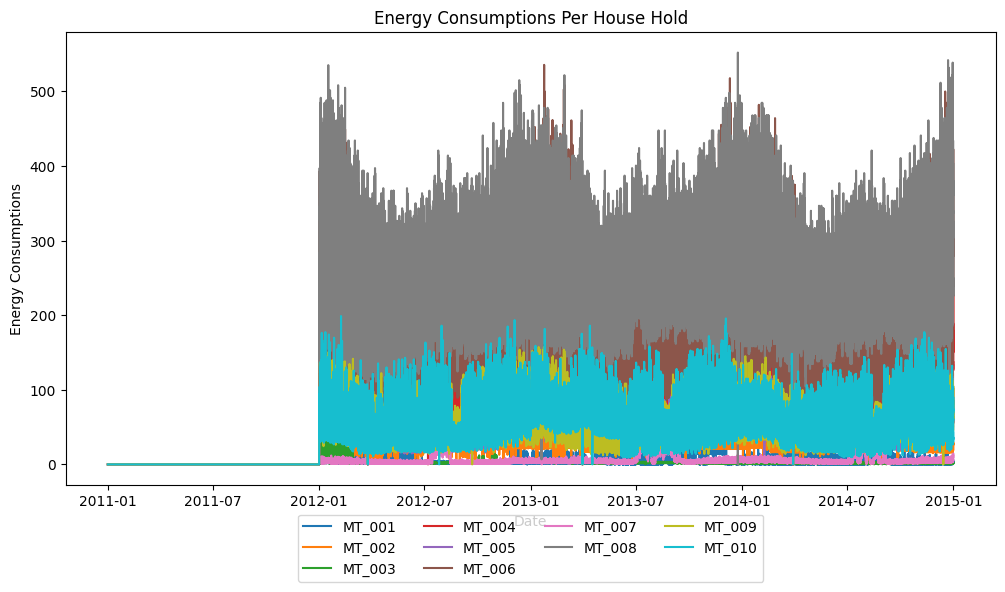

In [79]:
plt.figure(figsize=(12, 6), dpi=100, facecolor="w")
for col in df.columns[:10]:
    plt.plot(df[col], label = col)

plt.ylabel("Energy Consumptions")
plt.xlabel("Date")
plt.title("Energy Consumptions Per House Hold")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), shadow=False, ncol=4)
plt.show()

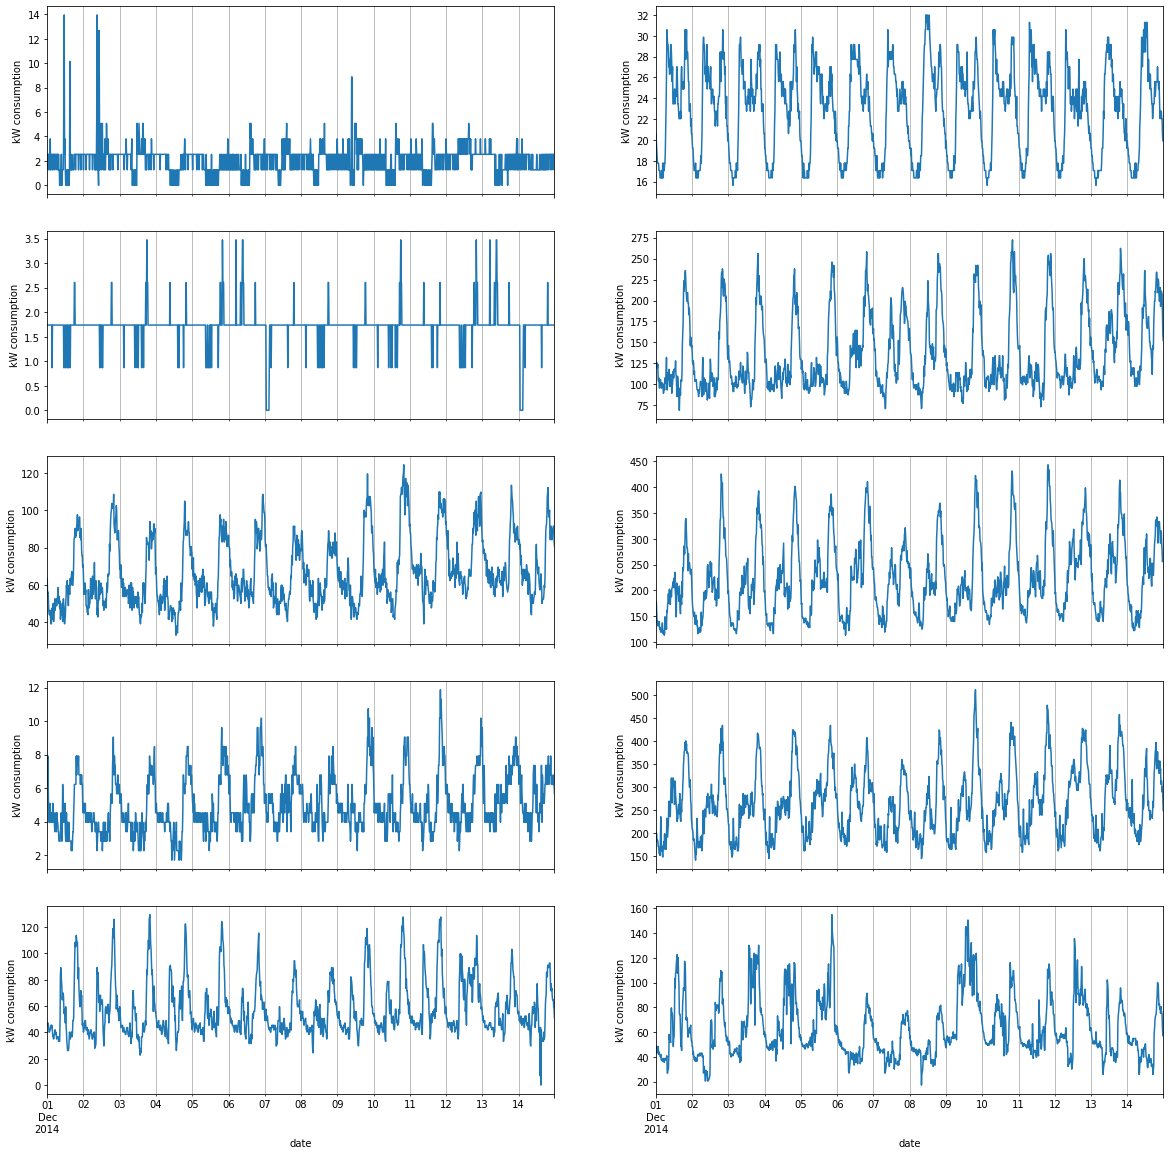

In [80]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    df[df.columns[i]].loc["2014-12-01":"2014-12-14"].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("kW consumption")   
    axx[i].grid(which='minor', axis='x')

In [81]:
df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
df_input = df.reset_index(drop=True).T.reset_index()
df_input.head()

,index,0,1,2,3,4,5,6,7,8,...,140246,140247,140248,140249,140250,140251,140252,140253,140254,140255
0,MT_001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.538071,1.269036,2.538071,2.538071,1.269036,2.538071,2.538071,2.538071,1.269036,2.538071
1,MT_002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.048364,22.048364,22.048364,22.048364,22.048364,22.048364,21.337127,20.625889,21.337127,19.914651
2,MT_003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619
3,MT_004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,156.504065,164.634146,160.569106,162.601626,156.504065,150.406504,166.666667,162.601626,166.666667,178.861789
4,MT_005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,86.585366,93.902439,87.804878,80.487805,85.365854,85.365854,81.707317,82.926829,85.365854,84.146341


In [83]:
ts_code=df_input["index"].astype('category').cat.codes.values
ts_code[0:7].reshape(-1,1)

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6]], dtype=int16)

In [85]:
df_train=df_input.iloc[:,1:134999].values
df_test=df_input.iloc[:,134999:].values

In [88]:
df_train.shape #?

(370, 134998)

In [86]:
freq="15min"
start_train = pd.Timestamp("2011-01-01 00:15:00", freq=freq)
start_test = pd.Timestamp("2014-11-07 05:30:00", freq=freq)
prediction_lentgh=672

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



In [89]:
estimator = DeepAREstimator(freq=freq, 
                            context_length=672,
                            prediction_length=prediction_lentgh,
                            use_feat_static_cat=True,
                            cardinality=[1],
                            num_layers=2,
                            num_cells=32,
                            cell_type='gru',
                            trainer=Trainer(epochs=5))

In [90]:
df_train[0:7].shape 


(7, 134998)

In [92]:

from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_train,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip(df_train[0:7],
                             ts_code[0:7].reshape(-1,1))
], freq=freq)

test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_test,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip(df_test,
                            ts_code.reshape(-1,1))
], freq=freq)

In [93]:
next(iter(train_ds))

{'feat_static_cat': array([0], dtype=int32),
 'start': Period('2011-01-01 00:15', '15T'),
 'target': array([0.       , 0.       , 0.       , ..., 2.5380712, 2.5380712,
        1.2690356], dtype=float32)}

In [95]:
[(target.shape, fsc.shape) for (target, fsc) in zip(df_train[0:7],ts_code[0:7].reshape(-1,1))]

[((134998,), (1,)),
 ((134998,), (1,)),
 ((134998,), (1,)),
 ((134998,), (1,)),
 ((134998,), (1,)),
 ((134998,), (1,)),
 ((134998,), (1,))]

In [96]:
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [03:05<00:00,  3.72s/it, epoch=5/5, avg_epoch_loss=2.16]


In [97]:
from gluonts.evaluation.backtest import make_evaluation_predictions


forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  
    predictor=predictor,  
    num_samples=100, 
)


In [98]:
from tqdm.autonotebook import tqdm

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(df_test)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(df_test)))


Obtaining time series conditioning values ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



  0%|          | 0/370 [00:00<?, ?it/s]

Obtaining time series predictions ...


  0%|          | 0/370 [00:00<?, ?it/s]

In [100]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = prediction_lentgh
    prediction_intervals = (80.0, 95.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)
    
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()


  0%|          | 0/6 [00:00<?, ?it/s]

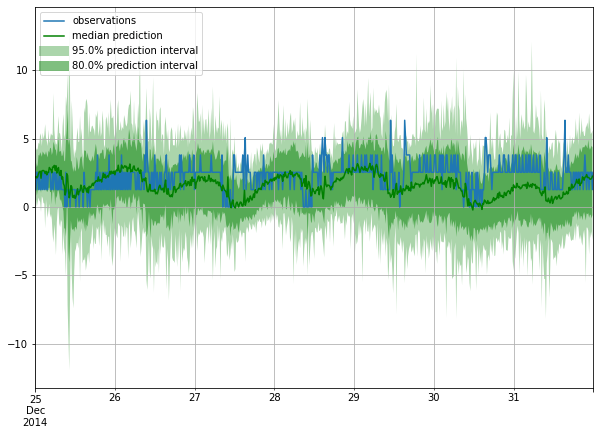

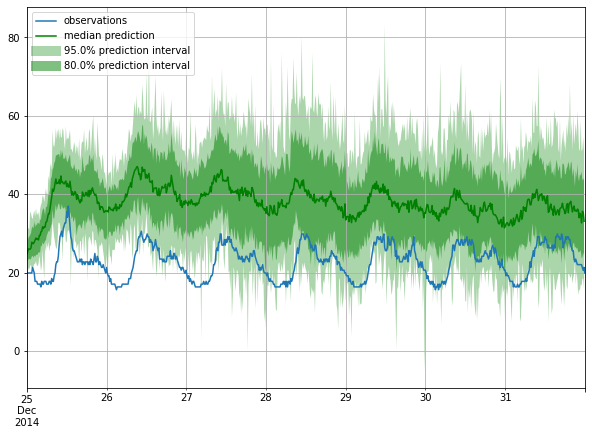

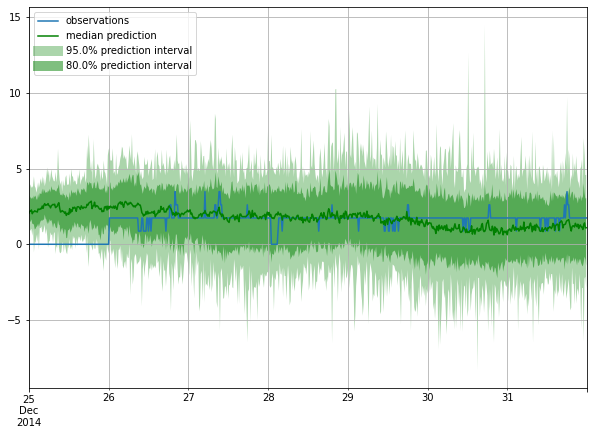

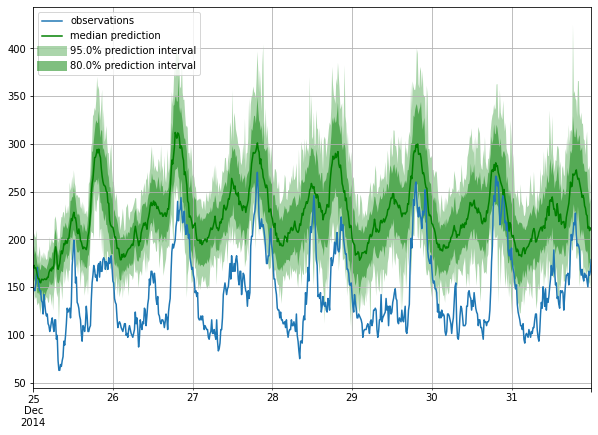

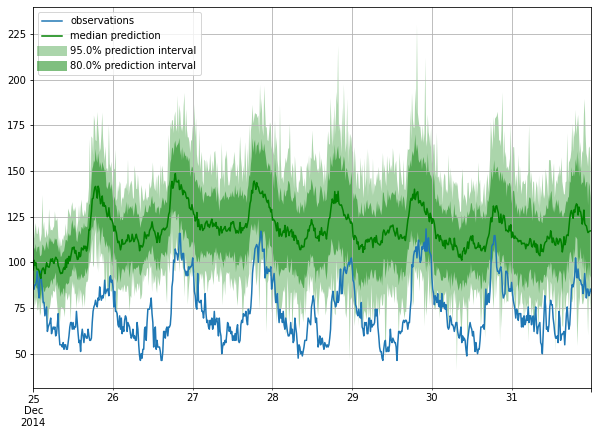

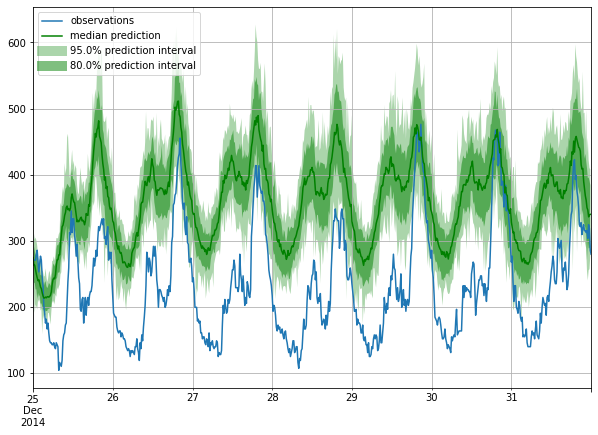

In [101]:

for i in tqdm(range(6)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry)


In [102]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(df_test))

Running evaluation: 100%|██████████| 370/370 [00:00<00:00, 2836.09it/s]
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:353: RuntimeWarning:

divide by zero encountered in float_scalars

/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/pandas/core/construction.py:759: UserWarning:




In [103]:
item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,1.916153e+00,7.002791e+02,1.513959e+03,2.252916,0.931286,1.118972,0.437914,0.613350,0.462548,9.557817,3.898829e+02,0.010417,7.002791e+02,0.302083,3.299682e+02,0.879464
1,NaN,2.457202e+02,1.027082e+04,1.532006e+04,22.797703,1.305572,11.706709,0.716243,0.511583,0.670416,81.297157,7.647477e+03,0.876488,1.027082e+04,1.000000,3.272409e+03,1.000000
2,NaN,1.129853e+00,4.992359e+02,9.843615e+02,1.464824,0.203948,3.642651,0.275664,0.548362,0.507167,44.993758,4.620715e+02,0.142857,4.992359e+02,0.559524,2.798412e+02,0.998512
3,NaN,6.900420e+03,5.302274e+04,9.845528e+04,146.510835,16.799753,4.696669,0.612857,0.447447,0.538546,77.507014,6.066582e+04,0.934524,5.302273e+04,0.995536,1.461115e+04,1.000000
4,NaN,2.097940e+03,2.970920e+04,4.930366e+04,73.368536,7.521593,5.877759,0.657125,0.477736,0.602576,78.805361,3.127926e+04,0.950893,2.970919e+04,0.998512,8.450873e+03,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,NaN,1.642698e+02,8.100516e+03,5.451141e+03,8.111817,8.533755,1.412548,2.409765,0.967193,1.486022,13.502675,7.378058e+03,0.846726,8.100516e+03,0.913690,2.591470e+03,0.962798
366,NaN,4.602774e+04,1.334238e+05,3.604776e+05,536.425037,81.746381,2.428820,0.409398,0.324613,0.370131,40.056746,1.520577e+05,0.928571,1.334238e+05,0.988095,3.671993e+04,1.000000
367,NaN,9.020405e+03,5.464260e+04,7.184307e+04,106.909331,43.768938,1.857788,1.465832,0.664117,0.760583,39.445825,6.865402e+04,0.840774,5.464260e+04,0.930060,1.473751e+04,0.973214
368,NaN,5.263087e+04,1.499515e+05,4.997705e+05,743.706148,54.752826,4.075445,0.304013,0.261657,0.300041,52.428332,1.584434e+05,0.994048,1.499515e+05,1.000000,4.247492e+04,1.000000


In [104]:
agg_metrics

{'Coverage[0.1]': 0.8734515765765766,
 'Coverage[0.5]': 0.9572554697554697,
 'Coverage[0.9]': 0.9817607786357786,
 'MAE_Coverage': 0.437489274989275,
 'MAPE': 1.1773171572528764,
 'MASE': inf,
 'MSE': 415899.66587205144,
 'MSIS': inf,
 'ND': 0.37063623570527815,
 'NRMSE': 1.2995019507189387,
 'OWA': nan,
 'QuantileLoss[0.1]': 53103995.76933251,
 'QuantileLoss[0.5]': 45733687.6471146,
 'QuantileLoss[0.9]': 17139950.291731983,
 'RMSE': 644.9028344425627,
 'abs_error': 45733687.87734985,
 'abs_target_mean': 496.269231520411,
 'abs_target_sum': 123392381.72523499,
 'mean_absolute_QuantileLoss': 38659211.236059695,
 'mean_wQuantileLoss': 0.31330306373487804,
 'sMAPE': 0.5645684166611239,
 'seasonal_error': 52.22279779373469,
 'wQuantileLoss[0.1]': 0.43036689159288843,
 'wQuantileLoss[0.5]': 0.37063623383939914,
 'wQuantileLoss[0.9]': 0.13890606577234654}